## Sentiment Analysis of Game Reviews

### The dataset used for training is composed of Steam game reviews sourced from Kaggle. (https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data)
### Test data was scraped from Google Play Store

---




# Install dan Import Libray

In [ ]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
import pandas as pd
pd.options.display.max_rows = None
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import joblib
from nltk.stem import PorterStemmer


### Import dataset


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
review = pd.read_csv('/content/drive/MyDrive/dataset/sentiment analysis game/steam review dataset.csv')
review.count()

CPU times: user 37.9 s, sys: 4.18 s, total: 42.1 s
Wall time: 1min


,0
app_id,6417106
app_name,6233872
review_text,6409801
review_score,6417106
review_votes,6417106


### Explore and Clean The Data

In [ ]:
null_counts = review.isnull().sum()

print(null_counts)

app_id               0
app_name        183234
review_text       7305
review_score         0
review_votes         0
dtype: int64


In [ ]:
review_clean = review.dropna().reset_index(drop=True)

In [ ]:
review_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6226728 entries, 0 to 6226727
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 237.5+ MB


In [ ]:
review_clean.head(10)

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1
5,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1
6,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,1
7,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben ...",1,1
8,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1
9,10,Counter-Strike,Every server is spanish or french. I can now f...,1,0


In [ ]:
# Count the occurrences of each value in the review_text
value_counts = review_clean["review_text"].value_counts()

# Filter to keep only those values that have more than one occurrence
duplicate_values = value_counts[value_counts > 1]

print("Duplicate values and their counts:")
print(duplicate_values.head(10))

Duplicate values and their counts:
review_text
 Early Access Review      977399
   Early Access Review     10571
10/10                       6050
.                           4769
Great game                  3662
great game                  3554
Great game!                 2440
:)                          2093
Nice game                   1793
Great Game                  1659
Name: count, dtype: int64


In [ ]:
# Remove duplicate rows based on 'column_name', keeping the first occurrence
review_clean = review_clean.drop_duplicates(subset=["review_text"], keep='first')

# Reset the index after dropping duplicates
review_clean = review_clean.reset_index(drop=True)

review_clean.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336555 entries, 0 to 4336554
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 165.4+ MB


In [ ]:
# Count the occurrences of each value in the review_text
value_counts = review_clean["review_text"].value_counts()

# Filter to keep only those values that have more than one occurrence
duplicate_values = value_counts[value_counts > 1]

print("Duplicate values and their counts:")
print(duplicate_values.head(10))

Duplicate values and their counts:
Series([], Name: count, dtype: int64)


### Include only the data where review_votes is 1 as it indicates that the data has been recommended by other users. We assume that this data is of high quality.

In [ ]:
# Filter the DataFrame to include only rows where review_votes is 1
filtered_reviews = review_clean[review_clean['review_votes'] == 1]

# Count the occurrences of 1 and -1 in the review_score column
score_counts = filtered_reviews['review_score'].value_counts()

print(score_counts)


review_score
 1    459783
-1    194037
Name: count, dtype: int64


### Reduce the positive sentiment so that the amount of data is balanced

In [ ]:
# Separate the positive and negative reviews
positive_reviews = filtered_reviews[filtered_reviews['review_score'] == 1]
negative_reviews = filtered_reviews[filtered_reviews['review_score'] == -1]

# Randomly sample from the positive reviews to match the number of negative reviews
sampled_positive_reviews = positive_reviews.sample(len(negative_reviews), random_state=42)

# Combine the sampled positive reviews with the negative reviews
balanced_reviews = pd.concat([sampled_positive_reviews, negative_reviews])

# shuffle the combined dataset
balanced_reviews = balanced_reviews.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_reviews['review_score'].value_counts())

review_score
 1    194037
-1    194037
Name: count, dtype: int64


In [ ]:
balanced_reviews.head(10)

,app_id,app_name,review_text,review_score,review_votes
0,208580,STAR WARS™ Knights of the Old Republic™ II: Th...,"Great game Come to the dark side, we have coo...",1,1
1,200210,Realm of the Mad God Exalt,This game is unplayable. The server lag is rid...,-1,1
2,298110,Far Cry 4,Graphics and environment are second to none......,1,1
3,261030,The Walking Dead: Season Two,Instructions to play this game. 1) Play it th...,1,1
4,283290,Nosferatu: The Wrath of Malachi,"Really cool game, but rough around the edges. ...",1,1
5,326340,River City Super Sports Challenge ~All Stars S...,Please Please Please re-make the soccer one wh...,1,1
6,376870,Minecraft: Story Mode - A Telltale Games Series,Dora the explorer by telltale games. Ignore th...,-1,1
7,351640,Eternal Senia,"This game is not free, as it requires you to b...",1,1
8,281610,Homeworld: Deserts of Kharak,I'm an avid fan of the Homeworld universe. Thi...,1,1
9,292120,FINAL FANTASY XIII,Update as of 4:12 PM PST: Fix is out by Durant...,-1,1


In [ ]:
balanced_reviews.to_csv("/content/drive/MyDrive/dataset/sentiment analysis game/clean steam review dataset.csv", index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/sentiment analysis game/clean steam review dataset.csv')

In [ ]:
df.review_text = df.review_text.astype('str')

### 10% of the data is used for validation

In [ ]:
# validation size as 10%
validation_size = 0.10

# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=validation_size, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 349266
Validation set size: 38808


# Analysis dan Visualization


## WordCloud

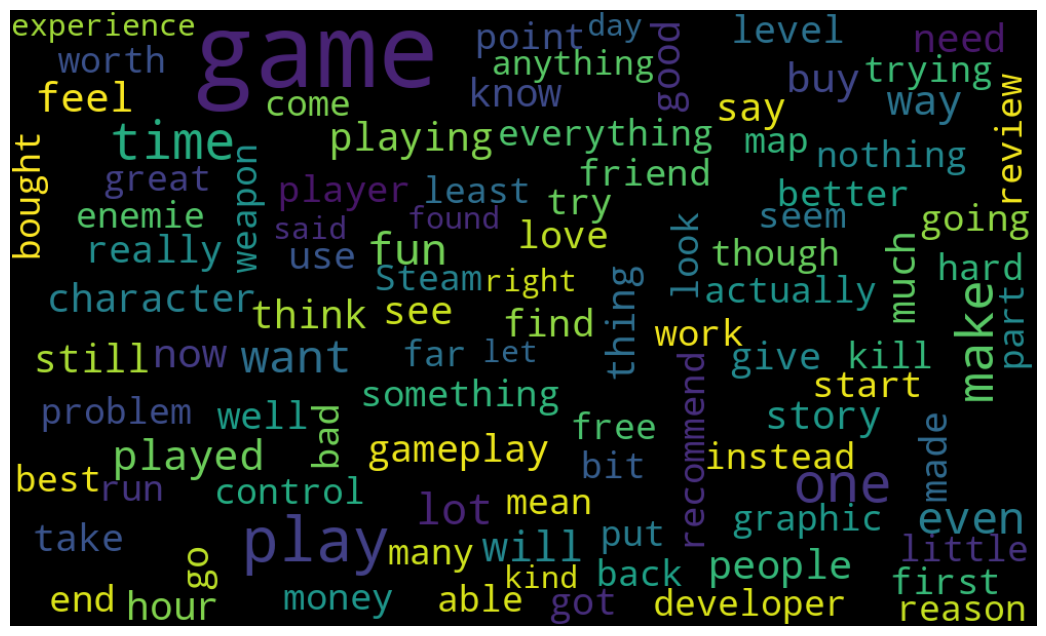

In [ ]:
txt = ' '.join(rev for rev in df.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## WordCloud for each sentiment

In [ ]:
positive = df[df['review_score']==1]
negative = df[df['review_score']==-1]

## Positive Sentiment Reviews

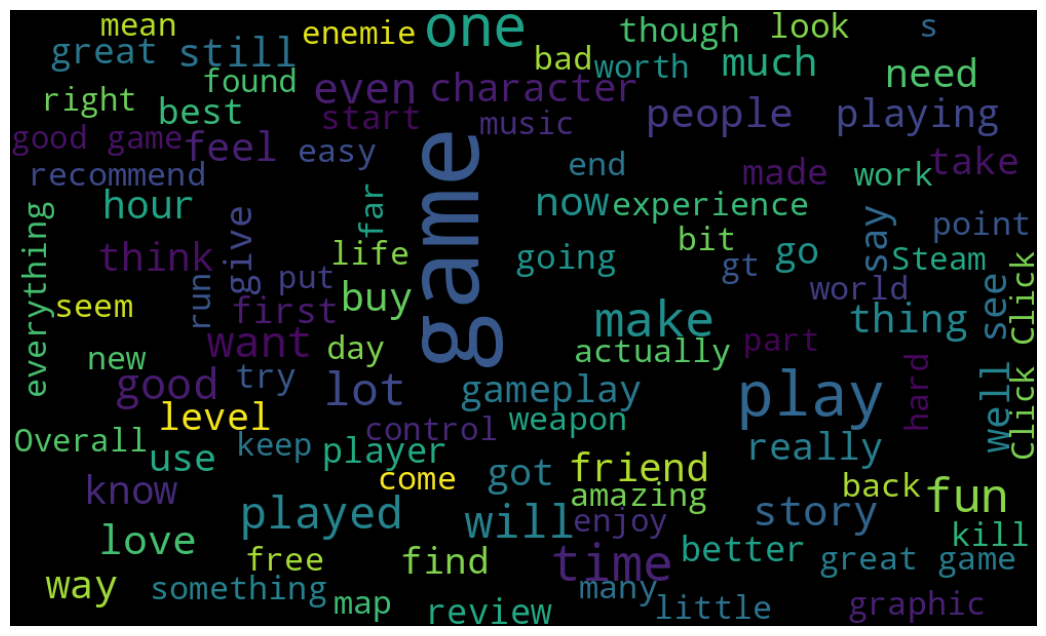

In [ ]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Negative Sentiment Reviews

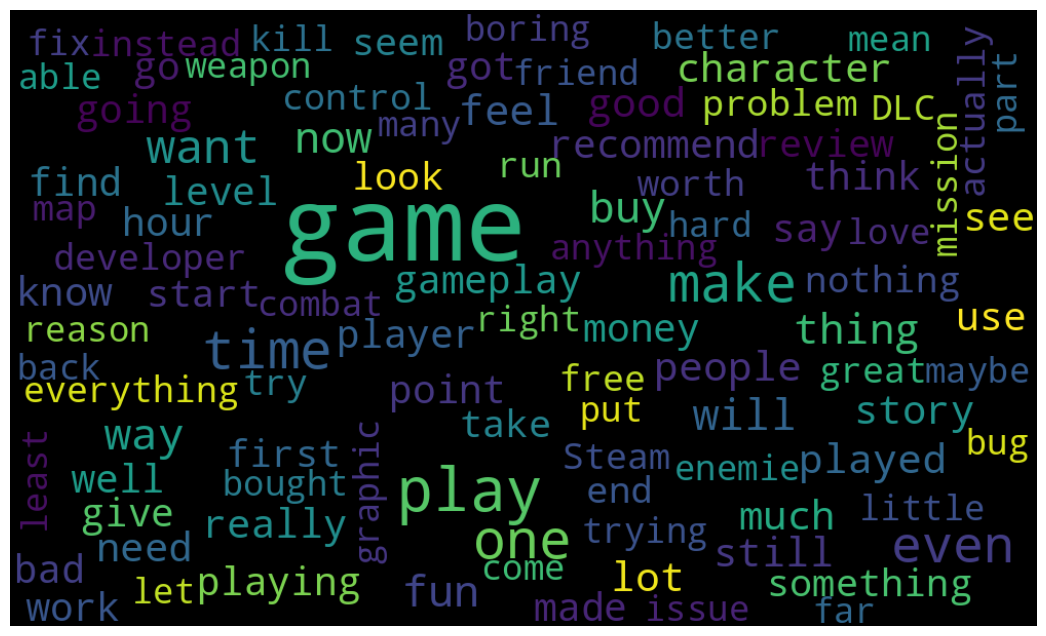

In [ ]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Distribution of word count per review

In [ ]:
review_vis = df.copy()

In [ ]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

<Axes: xlabel='Num_word_review', ylabel='Count'>

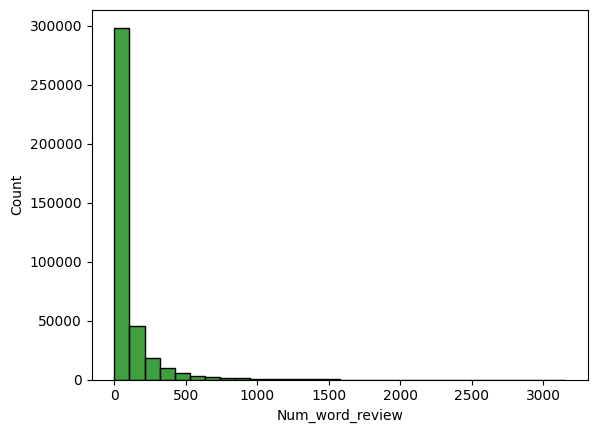

In [ ]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

## the most frequently occurring words


In [ ]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,1425096
1,to,930421
2,and,891022
3,a,863438
4,of,661025
5,I,590487
6,is,579750
7,you,526479
8,game,510516
9,it,403072


### There are still stop words in the review

## Text Cleaning

In [ ]:
# fungsi untuk menghilangkan yang bukan kata
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

# Fungsi untuk menghilangkan angka
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

# Fungsi untuk menghilangkan emoji
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

# Fungsi untuk menghapus whitespace
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

# Fungsi untuk menghilangkan simbol
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

# tanda baca
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

# stopword
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

# stemming
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

## Combine All The Function

In [ ]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [ ]:
def cleaning_text(text):
    text = clean(text)
    text = deEmojify(text)
    text = text.lower()
    text = remove_num(text)
    text = remove_symbols(text)
    text = remove_punctuation(text)
    text = remove_stopword(text)
    text = unify_whitespaces(text)
    text = Stemming(text)
    return text

### Clean the sentence in the dataframe

In [ ]:
cleaning(train_data,'review_text')
cleaning(val_data,'review_text')

In [ ]:
train_data.to_csv("/content/drive/MyDrive/dataset/sentiment analysis game/trainreview.csv", index=False)
val_data.to_csv("/content/drive/MyDrive/dataset/sentiment analysis game/valreview.csv", index=False)


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/dataset/sentiment analysis game/trainreview.csv')
val_data = pd.read_csv('/content/drive/MyDrive/dataset/sentiment analysis game/valreview.csv')

In [ ]:
train_data.review_text = train_data.review_text.astype('str')
val_data.review_text = val_data.review_text.astype('str')

### analyze the text again after cleaning

In [ ]:
review_vis2 = train_data.copy()

In [ ]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,752354
1,play,208542
2,like,173173
3,get,152576
4,time,113458
5,one,109552
6,good,92264
7,make,89181
8,even,88028
9,realli,84720


# Model Training

Models that are used for this training are Logistic Regression, Random Forest, and Naive Bayes

Text Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the training data
X_train = tfidf.fit_transform(train_data['review_text'])

# Transform the validation data
X_val = tfidf.transform(val_data['review_text'])

Prepare Labels

In [ ]:
y_train = train_data['review_score']
y_val = val_data['review_score']

Training and Evaluate Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the Model
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy}')

# Get detailed classification report
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.8136209029066171
              precision    recall  f1-score   support

          -1       0.82      0.80      0.81     19391
           1       0.81      0.82      0.82     19417

    accuracy                           0.81     38808
   macro avg       0.81      0.81      0.81     38808
weighted avg       0.81      0.81      0.81     38808



In [ ]:
import joblib

# Save the model
joblib.dump(model, '/content/drive/MyDrive/dataset/sentiment analysis game/logistic_regression_model.pkl')

# Save the TF-IDF Vectorizer
joblib.dump(tfidf, '/content/drive/MyDrive/dataset/sentiment analysis game/tfidf_vectorizer.pkl')

['/content/drive/MyDrive/dataset/sentiment analysis game/tfidf_vectorizer.pkl']

Training and Evaluate Naive Bayes

In [ ]:
%%time
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on validation data
y_pred_nb = nb_model.predict(X_val)

# Evaluate the model
accuracy_nb = accuracy_score(y_val, y_pred_nb)
print(f'Naive Bayes Validation Accuracy: {accuracy_nb}')
print(classification_report(y_val, y_pred_nb))

Naive Bayes Validation Accuracy: 0.7862554112554112
              precision    recall  f1-score   support

          -1       0.79      0.79      0.79     19391
           1       0.79      0.78      0.79     19417

    accuracy                           0.79     38808
   macro avg       0.79      0.79      0.79     38808
weighted avg       0.79      0.79      0.79     38808

CPU times: user 245 ms, sys: 1.92 ms, total: 247 ms
Wall time: 247 ms


In [ ]:
import joblib
joblib.dump(nb_model, '/content/drive/MyDrive/dataset/sentiment analysis game/nb_model.pkl')

['/content/drive/MyDrive/dataset/sentiment analysis game/nb_model.pkl']

Training and Evaluate Random Forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on validation data
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf}')
print(classification_report(y_val, y_pred_rf))

Random Forest Validation Accuracy: 0.7009637188208617
              precision    recall  f1-score   support

          -1       0.75      0.60      0.67     19391
           1       0.67      0.80      0.73     19417

    accuracy                           0.70     38808
   macro avg       0.71      0.70      0.70     38808
weighted avg       0.71      0.70      0.70     38808

CPU times: user 1min 20s, sys: 480 ms, total: 1min 21s
Wall time: 54.5 s


In [ ]:
import joblib
joblib.dump(rf_model, '/content/drive/MyDrive/dataset/sentiment analysis game/rf_model.pkl')

['/content/drive/MyDrive/dataset/sentiment analysis game/rf_model.pkl']

### We can see that the model with the best accuracy is Logistic Regression

### test with input text

In [ ]:
# Load the model and vectorizer
model = joblib.load('/content/drive/MyDrive/dataset/sentiment analysis game/logistic_regression_model.pkl')
tfidf = joblib.load('/content/drive/MyDrive/dataset/sentiment analysis game/tfidf_vectorizer.pkl')

# Example new data
new_text = "This is an amazing game!"
new_text2 = "This is a terrible game!"

# Clean and preprocess the new text
cleaned_text = cleaning_text(new_text)
cleaned_text2 = cleaning_text(new_text2)

# Transform the new text using the loaded vectorizer
new_text_tfidf = tfidf.transform([cleaned_text])
new_text_tfidf2 = tfidf.transform([cleaned_text2])

# Predict sentiment
prediction = model.predict(new_text_tfidf)
prediction2 = model.predict(new_text_tfidf2)

# Print the prediction
print(f'Predicted sentiment: {prediction[0]}')
print(f'Predicted sentiment: {prediction2[0]}')

Predicted sentiment: 1
Predicted sentiment: -1


# Scrap Data for Inference

Review data will be collected from the Google Play Store using google_play_scrapper library.

## Install and Import Libraries

In [ ]:
!pip install google-play-scraper

from google_play_scraper import app

import pandas as pd

import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00


## Reviews will be collected from the Roblox game, and only reviews with a score of 1 or 5 will be considered.

In [ ]:
from google_play_scraper import Sort, reviews

# Retrieve 5-star reviews
five_star_reviews, _ = reviews(
    'com.roblox.client',
    lang='en',
    country='us',
    sort=Sort.MOST_RELEVANT,
    count=500,  # Adjust the count as needed
    filter_score_with=5  # Filter by 5-star ratings
)

# Retrieve 1-star reviews
one_star_reviews, _ = reviews(
    'com.roblox.client',
    lang='en',
    country='us',
    sort=Sort.MOST_RELEVANT,
    count=500,  # Adjust the count as needed
    filter_score_with=1  # Filter by 1-star ratings
)

# Combine the two sets of reviews
combined_reviews = five_star_reviews + one_star_reviews

# Convert to a DataFrame
df_reviews = pd.DataFrame(combined_reviews)
df_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a3706465-ef80-43dc-a73d-bc0c313aa6f6,Daxton Gillis,https://play-lh.googleusercontent.com/a-/ALV-U...,"An amazing app with lots of fun, engaging, and...",5,16705,2.635.590,2024-07-31 17:41:24,None,None,2.635.590
1,55abecf4-0796-47dc-b2a9-4d111f9cec08,Brayden Sabold,https://play-lh.googleusercontent.com/a-/ALV-U...,"Amazing Game! I love the variety of games, ava...",5,838,2.635.590,2024-07-29 15:29:19,None,None,2.635.590
2,7ae0e117-04a1-41de-b2d9-7396c11a97e0,Gunnar Farley,https://play-lh.googleusercontent.com/a-/ALV-U...,Amazing adventures await! This game is so fun ...,5,141,2.636.626,2024-08-11 18:16:12,None,None,2.636.626
3,638d8e56-d4fc-412e-b5b8-1fadccc466b4,Blighted Obliteration,https://play-lh.googleusercontent.com/a-/ALV-U...,I wholeheartedly recommend this game. It was a...,5,2467,2.636.626,2024-08-08 02:58:33,None,None,2.636.626
4,2982fe30-52ca-4f80-8141-ac0ac46c6dbb,Pamela Bayas,https://play-lh.googleusercontent.com/a/ACg8oc...,It's so fun and you can create cool games and ...,5,2,2.637.730,2024-08-14 11:11:46,None,None,2.637.730


## Change the value of 5 to 1 and 1 to -1

In [ ]:
# Replace the values in the 'score' column
df_reviews['score'] = df_reviews['score'].replace({1: -1, 5: 1})

# Keep only the 'content' and 'score' columns
df_reviews = df_reviews[['content', 'score']]

# Display the DataFrame to verify the changes
print(df_reviews.head(5))

                                             content  score
0  An amazing app with lots of fun, engaging, and...      1
1  Amazing Game! I love the variety of games, ava...      1
2  Amazing adventures await! This game is so fun ...      1
3  I wholeheartedly recommend this game. It was a...      1
4  It's so fun and you can create cool games and ...      1


## Make the prediction with the best model which is Logistic Regression

In [ ]:
import joblib

# Load the model and vectorizer
model = joblib.load('/content/drive/MyDrive/dataset/sentiment analysis game/logistic_regression_model.pkl')
tfidf = joblib.load('/content/drive/MyDrive/dataset/sentiment analysis game/tfidf_vectorizer.pkl')

# Clean and preprocess the content column
df_reviews['cleaned_content'] = df_reviews['content'].apply(cleaning_text)

# Transform the cleaned content using the loaded vectorizer
df_reviews_tfidf = tfidf.transform(df_reviews['cleaned_content'])

# Predict sentiment for each review
df_reviews['prediction'] = model.predict(df_reviews_tfidf)

# Display the DataFrame to check the results
pd.set_option('display.max_colwidth', None)
df_reviews[['content', 'score', 'prediction']].tail()


,content,score,prediction
995,I regret giving it a two star earlier I was actually gonna give it 5 when I played earlier cause the error 268 was gone but when I came back it was back I'm starting to hate this game I spent over ₱1000+ on this game. And it gave me and error where I can't even play!?!?! If you don't remove this error I wont hesitate to sue,-1,-1
996,I can't play Roblox on my Xbox only on my phone and I don't like playing on my it's too small every time I try on my Xbox it says sign in or make another account I tried both and it wouldn't let me the game has gone downhill badly with all the hackers they take the fun out of the game it was a lot better around 2 years ago somebody needs to fix it or just shut it down I enjoyed it but now I can't,-1,-1
997,Roblox I have a problem idk it's the wifi or the servers of yours are going broken bc I can't play properly the menu is so slow to load everything. when it's loading this thing pop out said the servers are down every single time it's so annoying and the id 17 I don't even know what's that supposed to mean pls fix ALL OF IT FROM EXISTENCE,-1,-1
998,"Hi roblox, I am so pissed. Everytime I try to join your games, it's always Error: 268 even if I didn't do anything wrong. The Roblox server is not even down and so it really makes me upset. Fix this, I'm already behind on my grinding and everytime I try to log in onto one of my accounts it still says Error: 268. I didn't do anything wrong!!!!!",-1,-1
999,"I have to say my recent experience with Roblox has been deeply disappointing. The inflation issues on the platform have completely ruined the fun and fairness of the game. The cost of items has skyrocketed, making it nearly impossible to have a nice Avatar without constantly spending more money.",-1,-1


## See the accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(df_reviews['score'], df_reviews['prediction'])

# Print the accuracy
print(f'Prediction Accuracy: {accuracy:.4f}')

Prediction Accuracy: 0.8060
